# Planes

## Import section

In [121]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import io, color, feature, measure, morphology, util
from skimage.filters import threshold_sauvola, threshold_yen, threshold_minimum

## Download data

In [ ]:
!sudo apt-get install -y unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
drive.mount('/content/gdrive/')
os.chdir('/content')
rar_dir = '/content/gdrive/MyDrive/Kaggle/Samoloty.rar'

!cp '{rar_dir}' .
!unrar e 'Samoloty.rar'

os.listdir()

In [4]:
filenames = []
for filename in os.listdir():
  if filename[-3:] == "jpg":
    filenames.append(filename)

## Visualization

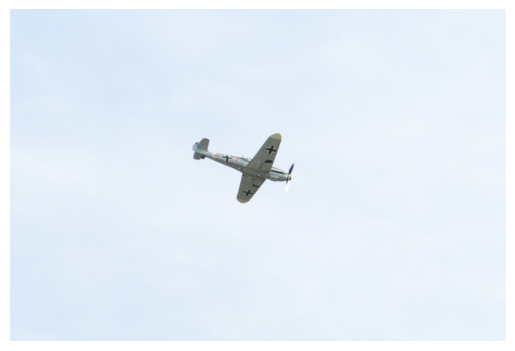

In [5]:
image = mpimg.imread(filenames[1])

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [51]:
problematic = [f for f in filenames if int(f[-6:-4]) in [2, 3, 4, 6, 18, 19, 15, 20]]

In [73]:
binaries_ready = []
original_images = []

In [ ]:
dilation_level = 3
erosion_level = 5
yen_const = 20

fig, ax = plt.subplots(ncols=6, nrows=len(filenames), figsize=(24, len(filenames) * 4))
plt.gray()

for index, value in enumerate(filenames):
  image = mpimg.imread(value)
  original_images.append(image)
  original = mpimg.imread(value)
  image_blue = image[:, :, 2]

  algorithms = [threshold_yen, threshold_minimum]
  binaries = []

  for al in algorithms:
    for erode in [True, False]:
      img = image_blue

      thresh = al(img)
      thresh_sauv = threshold_sauvola(img)
      binary = img > thresh
      binary_sauv = img > thresh_sauv

      binary = np.logical_and(binary, binary_sauv)

      if erode:
        binary = util.img_as_ubyte(binary)
        binary = morphology.dilation(binary, morphology.square(dilation_level))
        binary = morphology.erosion(binary, morphology.square(erosion_level))

      binaries.append(binary)

  ax[index, 0].imshow(binaries[0])
  ax[index, 0].set_title('YEN EROSION')

  ax[index, 1].imshow(binaries[1])
  ax[index, 1].set_title('YEN NO EROSION')

  ax[index, 2].imshow(binaries[2])
  ax[index, 2].set_title('MIN EROSION')

  ax[index, 3].imshow(binaries[3])
  ax[index, 3].set_title('MIN NO EROSION')

  ax[index, 4].imshow(image_blue, cmap='Blues')
  ax[index, 4].set_title('ORIGINAL')

  ax[index, 5].hist(image.ravel(), bins=256)
  br = image_blue.ravel()
  if (min(int(np.std(br)), int(np.max(br) - np.median(br))) < yen_const):
    binaries_ready.append(binaries[0])
    if_yen = 'YEN'
  else:
    binaries_ready.append(binaries[2])
    if_yen = ''
  ax[index, 5].set_title(f"{np.median(br)} {if_yen}")

  for a in range(5):
    ax[index, a].axis('off')


plt.show()

## Finding contours

In [126]:
def is_contour_closed(contour):
    return np.array_equal(contour[0], contour[-1])

def find_max_contour(file, contours):
    area_threshold_min = 200
    area_threshold_max = 5000

    height, width = file.shape
    num_pixels = height * width

    tab = []
    leng = 0
    for i in contours:
        if len(i) >= area_threshold_min and len(i) <= area_threshold_max:
            if is_contour_closed(i):
                tab.append(i)
                leng += len(i)
    tab2 = []
    if len(tab) <= 3:
        for i in tab:
            if len(i)/num_pixels*1000 >= 0.5: tab2.append(i)
        return tab2
    else: return tab

def plot_centroids(ax, contours):
    for contour in contours:
        centroid = np.mean(contour, axis=0)
        ax.plot(centroid[1], centroid[0], 'wo', markersize=3)

In [ ]:
for original, image in zip(original_images, binaries_ready):
  fig, ax = plt.subplots()
  ax.imshow(original)

  for level in range(45, 0, -25):
    contours = measure.find_contours(image, level/100)
    contour_tab = find_max_contour(image, contours)
    if len(contour_tab) > 0:
      for i in contour_tab:
        ax.plot(i[:, 1], i[:, 0], linewidth=2)
        ax.fill(i[:, 1], i[:, 0], color='black')
      plot_centroids(ax, contour_tab)
      break

  ax.axis('off')

## Summary

The utilized algorithm can detect airplanes in 19 out of 20 images, although it sometimes omits parts of airplanes with colors similar to the background.
In the solution, two algorithms were employed to find the threshold for which a pixel of a certain color can be considered as belonging to an airplane or the sky.

The threshold minimum algorithm performs well for bimodal distributions but struggles with two types of images: those with relatively uniform colors
(slight deviations in pixel color values from the median) and those with very high median values (in such cases, the algorithm mistakenly identifies darker airplane parts as background fragments).
To address these issues, an experimentally chosen constant, yen_const, was used. In the occurrence of these cases, the yen thresholding algorithm was employed.

The third algorithm, Savoula's threshold, is effective in detecting text. In this case, it aided in identifying airplane contours not visible against the sunlit background
(despite that, even though the airplanes were detected, gaps appeared in their contours, leading to two airplanes being marked with multiple colors).